
=== Running test config: Req20_Veh4_Reg0.1 ===
No solution found!

=== Running test config: Req30_Veh6_Reg0.2 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


Map saved to routes_Req30_Veh6_Reg0.2_20250321_100135.html



=== Running test config: Req10_Veh2_Reg0.05 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


Map saved to routes_Req10_Veh2_Reg0.05_20250321_100204.html



--- Raw Results (All Configurations) ---
   distance_miles  sim_time_min              Config  NumRequests  NumVehicles  \
0         276.314       552.628   Req30_Veh6_Reg0.2           30            6   
1          38.765        77.530  Req10_Veh2_Reg0.05           10            2   

   RegionSize  
0        0.20  
1        0.05  


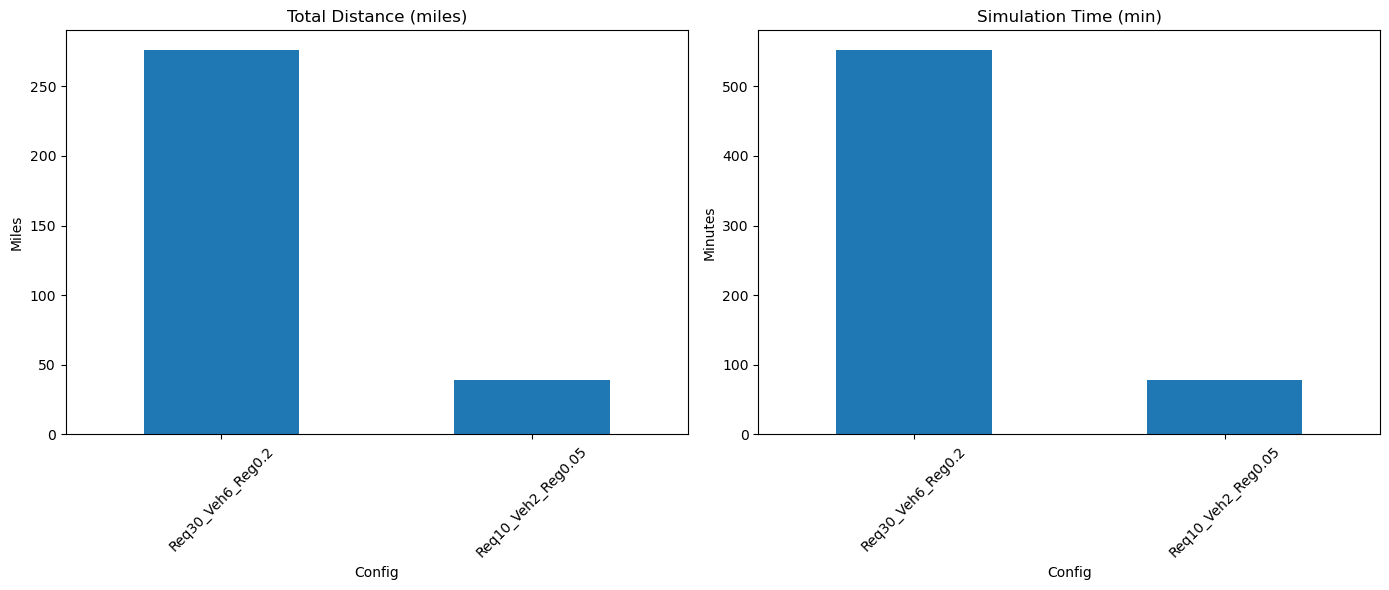

Grouped bar chart saved to grouped_comparison.png
Results page saved to results.html


In [2]:
import sys
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os

# Use perf_counter for high-resolution timing if needed (here we use it only for solver time)
from time import perf_counter

from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from haversine import haversine, Unit
import folium
import osmnx as ox
import networkx as nx

# For Jupyter display if needed
IN_JUPYTER = 'ipykernel' in sys.modules
if IN_JUPYTER:
    from IPython.display import display

# -----------------------------------
# CONFIGURATION
# -----------------------------------
# Test configurations with varying request count, vehicle count, and region size.
TEST_CONFIGS = [
    {"num_requests": 20, "num_vehicles": 4, "region_size": 0.1},
    {"num_requests": 30, "num_vehicles": 6, "region_size": 0.2},
    {"num_requests": 10, "num_vehicles": 2, "region_size": 0.05}
]
TIME_LIMIT_SEC = 15         # Solver time limit in seconds

# --------------------------------------------------
# Create Data (with accessibility for vehicles & passengers)
# --------------------------------------------------
def create_rural_data(num_requests=8, num_vehicles=3, region_size=0.1):
    """
    Generates a 'rural' dial-a-ride problem over an area defined by region_size (in degrees).

    For each request:
      - Pickup and dropoff coordinates are randomly generated within ±region_size of a center point.
      - A random time window is set.
      - Accessibility needs are randomly assigned (bike and/or wheelchair).

    Vehicles are also given random accessibility capabilities.
    """
    center_lat, center_lon = 30.1897, -82.6393  # Example center (Lake City, FL)
    lat_range = region_size
    lon_range = region_size

    # Depot at center
    locations = [("Depot", center_lat, center_lon)]
    
    requests = []
    accessibility_requirements = {}  # Map pickup node index -> (needs_bike, needs_wheelchair)
    for i in range(num_requests):
        # Random pickup and dropoff locations
        pickup_lat = center_lat + random.uniform(-lat_range, lat_range)
        pickup_lon = center_lon + random.uniform(-lon_range, lon_range)
        dropoff_lat = center_lat + random.uniform(-lat_range, lat_range)
        dropoff_lon = center_lon + random.uniform(-lon_range, lon_range)
        
        # Time window: earliest between 7:00 AM and 3:00 PM, latest at least 2 hours later up to 8:00 PM.
        earliest = random.randint(420, 900)
        latest = random.randint(earliest + 120, 1200)
        window = (earliest, latest)
        
        # Random accessibility needs for the passenger
        needs_bike = random.choice([True, False])
        needs_wheelchair = random.choice([True, False])
        
        req = {
            "name": f"R{i+1}",
            "pickup_lat": pickup_lat,
            "pickup_lon": pickup_lon,
            "dropoff_lat": dropoff_lat,
            "dropoff_lon": dropoff_lon,
            "time_window": window,
            "needs_bike": needs_bike,
            "needs_wheelchair": needs_wheelchair
        }
        requests.append(req)
    
    # Build location list: depot, then pickup and dropoff nodes for each request.
    for i, req in enumerate(requests):
        locations.append((f"{req['name']}_pickup", req["pickup_lat"], req["pickup_lon"]))
        locations.append((f"{req['name']}_dropoff", req["dropoff_lat"], req["dropoff_lon"]))
        # Map the pickup node index (1 + 2*i) to its accessibility requirements.
        accessibility_requirements[1 + 2*i] = (req["needs_bike"], req["needs_wheelchair"])
    
    data = {}
    data["num_vehicles"] = num_vehicles
    data["depot"] = 0
    data["vehicle_capacities"] = [12] * num_vehicles  # Increased capacity
    
    # Generate a distance matrix using the haversine formula
    import numpy as np
    num_locs = len(locations)
    dist_mat = np.zeros((num_locs, num_locs))
    for i in range(num_locs):
        for j in range(num_locs):
            coord1 = (locations[i][1], locations[i][2])
            coord2 = (locations[j][1], locations[j][2])
            dist_mat[i][j] = haversine(coord1, coord2, unit=Unit.MILES)
    
    data["distance_matrix"] = (dist_mat * 1000).astype(int).tolist()
    # Assume 30 mph for travel time calculation
    time_mat = (dist_mat / 30.0) * 60.0  # minutes
    data["time_matrix"] = (time_mat * 1000).astype(int).tolist()
    
    # Demands: 0 for depot, +1 for pickup, -1 for dropoff.
    data["demands"] = [0] * num_locs
    data["pickups_deliveries"] = []
    data["time_windows"] = []
    
    # Depot time window: full day [0, 1440]
    data["time_windows"].append((0, 1440))
    
    # Mapping from node index to request name for labeling.
    passenger_node_to_name = {}
    for i, req in enumerate(requests):
        pu_idx = 1 + 2*i
        do_idx = pu_idx + 1
        data["pickups_deliveries"].append([pu_idx, do_idx])
        data["demands"][pu_idx] = 1
        data["demands"][do_idx] = -1
        passenger_node_to_name[pu_idx] = req["name"]
        passenger_node_to_name[do_idx] = req["name"]
        # Set same time window for both pickup and dropoff.
        data["time_windows"].append(req["time_window"])
        data["time_windows"].append(req["time_window"])
    
    # Add vehicles' accessibility capabilities: randomly assign each vehicle.
    data["vehicles"] = []
    for v in range(num_vehicles):
        bike_capable = random.choice([True, False])
        wheelchair_accessible = random.choice([True, False])
        data["vehicles"].append({
            "bike_capable": bike_capable,
            "wheelchair_accessible": wheelchair_accessible
        })
    return data, locations, passenger_node_to_name, accessibility_requirements

# --------------------------------------------------
# Solve the Routing Problem with Accessibility Constraints
# --------------------------------------------------
def solve_routing(data, locations, passenger_node_to_name, accessibility_requirements,
                  fs_strategy="PCA", ls_heuristic="GLS", time_limit=60):
    """
    Sets up and solves the routing problem.
    Accessibility requirements for pickups are enforced by restricting the allowed vehicles.
    Skipping is removed so all requests are forced to be served.
    """
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]),
                                           data["num_vehicles"],
                                           data["depot"])
    routing = pywrapcp.RoutingModel(manager)
    
    # Distance callback
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]
    dist_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb_idx)
    
    # Demand / Capacity dimension
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]
    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(demand_cb_idx, 0,
                                            data["vehicle_capacities"],
                                            True, "Capacity")
    
    # Time dimension
    def time_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["time_matrix"][from_node][to_node]
    time_cb_idx = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(time_cb_idx, 30_000, 24 * 60 * 60 * 1000,
                         False, "Time")
    time_dim = routing.GetDimensionOrDie("Time")
    
    # Set time windows for each node
    for loc_idx, tw in enumerate(data["time_windows"]):
        idx = manager.NodeToIndex(loc_idx)
        time_dim.CumulVar(idx).SetRange(tw[0] * 60_000, tw[1] * 60_000)
    
    # Pickup and delivery constraints
    for (pu_idx, do_idx) in data["pickups_deliveries"]:
        pu = manager.NodeToIndex(pu_idx)
        do = manager.NodeToIndex(do_idx)
        routing.AddPickupAndDelivery(pu, do)
        routing.solver().Add(routing.VehicleVar(pu) == routing.VehicleVar(do))
        routing.solver().Add(time_dim.CumulVar(pu) <= time_dim.CumulVar(do))
    
    # Enforce accessibility constraints on pickup nodes.
    for pu_idx, (needs_bike, needs_wheelchair) in accessibility_requirements.items():
        allowed_vehicles = []
        for v, vehicle in enumerate(data["vehicles"]):
            if needs_bike and (not vehicle["bike_capable"]):
                continue
            if needs_wheelchair and (not vehicle["wheelchair_accessible"]):
                continue
            allowed_vehicles.append(v)
        if allowed_vehicles:
            routing.SetAllowedVehiclesForIndex(allowed_vehicles, manager.NodeToIndex(pu_idx))
    
    # Set search parameters: using only PATH_CHEAPEST_ARC and GUIDED_LOCAL_SEARCH.
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.FromSeconds(time_limit)
    search_params.log_search = True
    
    start_time = perf_counter()
    solution = routing.SolveWithParameters(search_params)
    _ = perf_counter() - start_time  # We no longer record computation time
    
    if not solution:
        print("No solution found!")
        return None, None
    
    routes = []
    for v in range(data["num_vehicles"]):
        index = routing.Start(v)
        route_nodes = []
        while not routing.IsEnd(index):
            node_idx = manager.IndexToNode(index)
            route_nodes.append(node_idx)
            index = solution.Value(routing.NextVar(index))
        routes.append(route_nodes)
    
    # Calculate total distance and simulation time (based on travel speed)
    total_dist_miles = solution.ObjectiveValue() / 1000.0
    sim_time_min = (total_dist_miles / 30.0) * 60.0
    
    metrics = {
        "distance_miles": total_dist_miles,
        "sim_time_min": sim_time_min
    }
    return metrics, routes

# --------------------------------------------------
# Visualization: Maps for Routes
# --------------------------------------------------
def visualize_routes(routes, data, locations, passenger_node_to_name,
                     accessibility_requirements, map_filename):
    """
    Visualizes the routes on a Folium map with custom icons and labels.
    Displays the map inline in a Jupyter Lab Notebook.
    """
    depot_lat, depot_lon = locations[0][1], locations[0][2]
    m = folium.Map(location=[depot_lat, depot_lon], zoom_start=10)
    
    # Try to get an OSM graph for routing lines
    try:
        G = ox.graph_from_point((depot_lat, depot_lon), dist=30000, network_type='drive')
        G = G.to_undirected()
    except Exception as e:
        print("OSMnx error, using direct coordinates.", e)
        G = None
    
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
              'cadetblue', 'darkgreen', 'darkpurple', 'pink']
    
    # Pre-compute nearest nodes if possible
    node_ids = []
    if G:
        for loc in locations:
            lat, lon = loc[1], loc[2]
            try:
                node = ox.distance.nearest_nodes(G, lon, lat)
                node_ids.append(node)
            except:
                node_ids.append(None)
    else:
        node_ids = [None] * len(locations)
    
    for v_idx, route in enumerate(routes):
        color = colors[v_idx % len(colors)]
        path = []
        valid = True
        
        # Build route path
        for i in range(len(route) - 1):
            if not G:
                path.append(route[i])
            else:
                o_node = node_ids[route[i]]
                d_node = node_ids[route[i+1]]
                if o_node is None or d_node is None:
                    valid = False
                    break
                try:
                    seg = nx.shortest_path(G, o_node, d_node, weight='length')
                    path.extend(seg)
                except nx.NetworkXNoPath:
                    valid = False
                    break
        
        if not valid or not path:
            continue
        
        if G:
            coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]
        else:
            coords = [(locations[i][1], locations[i][2]) for i in route]
        
        folium.PolyLine(coords, color=color, weight=2.5).add_to(m)
        
        # Place markers for each node
        for node_idx in route:
            lat, lon = locations[node_idx][1], locations[node_idx][2]
            dem = data["demands"][node_idx]
            
            if dem == 1:
                point_type = "Pickup"
                name = passenger_node_to_name.get(node_idx, "Pickup")
            elif dem == -1:
                point_type = "Dropoff"
                name = passenger_node_to_name.get(node_idx, "Dropoff")
            else:
                point_type = "Depot"
                name = "Depot"
            
            # Get accessibility needs for pickups (default for others)
            needs_bike, needs_wheelchair = (False, False)
            if node_idx in accessibility_requirements:
                needs_bike, needs_wheelchair = accessibility_requirements[node_idx]
            
            # Choose icon based on accessibility needs
            icon_name = "info-sign"
            if needs_bike and needs_wheelchair:
                icon_name = "handicap"
            elif needs_bike:
                icon_name = "bicycle"
            elif needs_wheelchair:
                icon_name = "wheelchair"
            
            popup_text = f"{point_type}: {name}"
            if needs_bike or needs_wheelchair:
                popup_text += " ("
                if needs_bike:
                    popup_text += "Bike "
                if needs_wheelchair:
                    popup_text += "Wheelchair "
                popup_text = popup_text.strip() + ")"
            tooltip_text = f"{point_type} - {name}"
            
            folium.Marker(
                (lat, lon),
                icon=folium.Icon(color=color, icon=icon_name, prefix='fa'),
                popup=popup_text,
                tooltip=tooltip_text
            ).add_to(m)
    
    m.save(map_filename)
    print(f"Map saved to {map_filename}")
    if IN_JUPYTER:
        display(m)

# --------------------------------------------------
# Build a Results Page (HTML) with Charts & Map Links
# --------------------------------------------------
def build_results_page(df, map_files, chart_file):
    """
    Creates an HTML page with a summary table, a chart, and links to each map.
    """
    html = "<html><head><title>Routing Results</title></head><body>"
    html += "<h1>Routing Test Results</h1>"
    html += "<h2>Aggregated Metrics</h2>"
    html += df.to_html(index=False)
    html += f"<h2>Comparison Chart</h2><img src='{chart_file}' alt='Grouped Bar Chart'>"
    html += "<h2>Route Maps</h2><ul>"
    for cfg, mapfile in map_files.items():
        html += f"<li><a href='{mapfile}' target='_blank'>Config: {cfg}</a></li>"
    html += "</ul></body></html>"
    with open("results.html", "w") as f:
        f.write(html)
    print("Results page saved to results.html")

# --------------------------------------------------
# Main function: run tests and build charts & results page
# --------------------------------------------------
def main():
    all_runs = []
    map_files = {}
    
    # Loop over test configurations
    for config in TEST_CONFIGS:
        num_requests = config["num_requests"]
        num_vehicles = config["num_vehicles"]
        region_size = config["region_size"]
        config_label = f"Req{num_requests}_Veh{num_vehicles}_Reg{region_size}"
        print(f"\n=== Running test config: {config_label} ===")
        
        data, locations, passenger_node_to_name, accessibility_requirements = create_rural_data(
            num_requests=num_requests,
            num_vehicles=num_vehicles,
            region_size=region_size
        )
        
        metrics, routes = solve_routing(data, locations, passenger_node_to_name,
                                        accessibility_requirements,
                                        fs_strategy="PCA", ls_heuristic="GLS",
                                        time_limit=TIME_LIMIT_SEC)
        if metrics is None:
            continue
        
        # Record metrics (only total distance and simulation time)
        metrics.update({
            "Config": config_label,
            "NumRequests": num_requests,
            "NumVehicles": num_vehicles,
            "RegionSize": region_size
        })
        all_runs.append(metrics)
        
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        mapfile = f"routes_{config_label}_{ts}.html"
        visualize_routes(routes, data, locations, passenger_node_to_name,
                         accessibility_requirements, mapfile)
        map_files[config_label] = mapfile
    
    if not all_runs:
        print("No solutions found for any configuration!")
        return
    
    df = pd.DataFrame(all_runs)
    print("\n--- Raw Results (All Configurations) ---")
    print(df)
    
    # Set "Config" as the index and plot only the two metrics
    df_indexed = df.set_index("Config")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    df_indexed["distance_miles"].plot(kind="bar", ax=axes[0], rot=45, width=0.5)
    axes[0].set_title("Total Distance (miles)")
    axes[0].set_ylabel("Miles")
    
    df_indexed["sim_time_min"].plot(kind="bar", ax=axes[1], rot=45, width=0.5)
    axes[1].set_title("Simulation Time (min)")
    axes[1].set_ylabel("Minutes")
    
    plt.tight_layout()
    chart_filename = "grouped_comparison.png"
    plt.savefig(chart_filename)
    plt.show()
    print(f"Grouped bar chart saved to {chart_filename}")
    
    build_results_page(df, map_files, chart_filename)

if __name__ == "__main__":
    main()
